In [1]:
import pandas as pd
import numpy as np
import torch
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from pytorch_tabnet.tab_model import TabNetClassifier


import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
plt.rcParams.update({
    'text.usetex':False,
    'font.family':'monospace'
})  

Simple Bootstrapping method to get an confidence interval on the AUROC score.

In [2]:
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=2000, ci=0.95):
    rng = np.random.default_rng(42)
    aucs = []

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    for _ in range(n_bootstraps):
        idx = rng.integers(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_scores[idx]))

    lower = np.percentile(aucs, (1 - ci) / 2 * 100)
    upper = np.percentile(aucs, (1 + ci) / 2 * 100)
    return np.mean(aucs), lower, upper

Loading the dataset, pre-processing, and analysing the data

In [3]:
cohort_data = pd.read_csv('../cohort_data_new.csv')
cohort_data

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,...,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
0,200003,13.375000,3.583195,9.0,21.0,25.250000,3.105295,18.0,28.0,7.771429,...,10.0,21.0,26.471429,13.176711,13.2,43.9,48,M,141,0
1,200007,15.500000,2.121320,14.0,17.0,23.000000,1.414214,22.0,24.0,8.900000,...,8.0,10.0,10.300000,1.272792,9.4,11.2,44,M,30,0
2,200009,9.500000,2.121320,8.0,11.0,23.333333,2.081666,21.0,25.0,8.000000,...,15.0,21.0,12.471429,1.471637,10.5,14.3,47,F,51,0
3,200012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.900000,NaN,4.9,4.9,33,F,10,0
4,200014,10.000000,1.732051,9.0,12.0,24.000000,1.000000,23.0,25.0,7.733333,...,21.0,24.0,13.233333,2.203028,10.7,14.7,85,M,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30484,299992,15.375000,2.856153,11.0,25.0,23.125000,2.609556,15.0,26.0,8.307143,...,8.0,23.0,14.134783,3.781727,8.1,22.1,41,M,499,0
30485,299993,9.400000,1.341641,8.0,11.0,29.600000,2.073644,26.0,31.0,8.000000,...,12.0,15.0,12.600000,0.605530,12.0,13.3,26,M,67,0
30486,299994,16.157895,2.477973,13.0,24.0,21.631579,3.451417,17.0,31.0,8.100000,...,28.0,63.0,10.076190,2.642329,5.3,14.5,74,F,152,1
30487,299998,11.500000,1.732051,10.0,14.0,23.500000,1.290994,22.0,25.0,8.800000,...,20.0,22.0,9.900000,1.210372,7.9,11.0,87,M,46,1


In [4]:
lab_cols = [
    'anion_gap_mean', 'anion_gap_min', 'anion_gap_max', 'anion_gap_sd',
    'bicarbonate_mean', 'bicarbonate_min', 'bicarbonate_max', 'bicarbonate_sd',
    'calcium_total_mean', 'calcium_total_min', 'calcium_total_max', 'calcium_total_sd',
    'chloride_mean', 'chloride_min', 'chloride_max', 'chloride_sd',
    'creatinine_mean', 'creatinine_min', 'creatinine_max', 'creatinine_sd',
    'glucose_mean', 'glucose_min', 'glucose_max', 'glucose_sd',
    'hematocrit_mean', 'hematocrit_min', 'hematocrit_max', 'hematocrit_sd',
    'hemoglobin_mean', 'hemoglobin_min', 'hemoglobin_max', 'hemoglobin_sd',
    'mchc_mean', 'mchc_min', 'mchc_max', 'mchc_sd',
    'mcv_mean', 'mcv_min', 'mcv_max', 'mcv_sd',
    'magnesium_mean', 'magnesium_min', 'magnesium_max', 'magnesium_sd',
    'pt_mean', 'pt_min', 'pt_max', 'pt_sd',
    'phosphate_mean', 'phosphate_min', 'phosphate_max', 'phosphate_sd',
    'platelet_count_mean', 'platelet_count_min', 'platelet_count_max', 'platelet_count_sd',
    'potassium_mean', 'potassium_min', 'potassium_max', 'potassium_sd',
    'rdw_mean', 'rdw_min', 'rdw_max', 'rdw_sd',
    'red_blood_cells_mean', 'red_blood_cells_min', 'red_blood_cells_max', 'red_blood_cells_sd',
    'sodium_mean', 'sodium_min', 'sodium_max', 'sodium_sd',
    'urea_nitrogen_mean', 'urea_nitrogen_min', 'urea_nitrogen_max', 'urea_nitrogen_sd',
    'white_blood_cells_mean', 'white_blood_cells_min', 'white_blood_cells_max', 'white_blood_cells_sd',
    'age', 'icu_los_hours'
]

In [5]:
# REmove the ICUstay_id and the gender
drop_cols = [c for c in cohort_data.columns if 'icustay_id' in c.lower() or 'gender' in c.lower()]
df = cohort_data.drop(columns=['icustay_id', 'gender'], errors='ignore')

X = df.drop(columns=['target'])
y = df['target']
imputer = SimpleImputer(strategy="median")
df[lab_cols] = imputer.fit_transform(df[lab_cols])

# Keep only numeric
X = X.select_dtypes(include=['number']).replace([np.inf, -np.inf], np.nan)

print(f"Final feature matrix shape: {X.shape}")

Final feature matrix shape: (30489, 90)


Simple Imputation to handle the missing/ NaN values

In [6]:
# train-test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.30, random_state=7, stratify=y, shuffle=True)

# train-dev
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.30, random_state=7, stratify=y_train_full, shuffle=True)

imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

In [7]:
# Normalizing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f'% readmission in train: {np.mean(y_train)*100}')
print(f'% readmission in train: {np.mean(y_val)*100}')
print(f'% readmission in train: {np.mean(y_test)*100}')

% readmission in train: 10.74369101010777
% readmission in train: 10.74496329845385
% readmission in train: 10.746692904777523


Hyperparameter Tuning

In [8]:
def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 16, 64),
        "n_a": trial.suggest_int("n_a", 16, 64),
        "n_steps": trial.suggest_int("n_steps", 3, 7),
        "gamma": trial.suggest_float("gamma", 1.0, 2.5),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True),
        "optimizer_fn": torch.optim.Adam,
        "optimizer_params": dict(lr=trial.suggest_float("lr", 1e-4, 3e-3, log=True)),
        "mask_type": "sparsemax",
    }

    model = TabNetClassifier(**params)

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
        eval_metric=["auc"],
        max_epochs=150,
        patience=15,
        batch_size=2048,
        virtual_batch_size=256,
        num_workers=0,
        drop_last=False,
    )

    # Predict on validation test split
    val_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_pred_proba)

    return auc

In [9]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best AUC:", study.best_value)
print("Best parameters:", study.best_params)


[I 2025-12-02 22:34:46,585] A new study created in memory with name: no-name-58071c95-7920-42c9-8741-cfe276f72f9a


  0%|          | 0/40 [00:00<?, ?it/s]

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98465 | val_0_auc: 0.49295 |  0:00:05s
epoch 1  | loss: 0.81801 | val_0_auc: 0.46961 |  0:00:11s
epoch 2  | loss: 0.74955 | val_0_auc: 0.47303 |  0:00:16s
epoch 3  | loss: 0.66614 | val_0_auc: 0.48388 |  0:00:22s
epoch 4  | loss: 0.65724 | val_0_auc: 0.47805 |  0:00:27s
epoch 5  | loss: 0.64337 | val_0_auc: 0.48259 |  0:00:32s
epoch 6  | loss: 0.64311 | val_0_auc: 0.47977 |  0:00:37s
epoch 7  | loss: 0.6204  | val_0_auc: 0.48112 |  0:00:42s
epoch 8  | loss: 0.62722 | val_0_auc: 0.47725 |  0:00:47s
epoch 9  | loss: 0.59478 | val_0_auc: 0.49146 |  0:00:53s
epoch 10 | loss: 0.59118 | val_0_auc: 0.50596 |  0:01:00s
epoch 11 | loss: 0.57635 | val_0_auc: 0.4939  |  0:01:05s
epoch 12 | loss: 0.56144 | val_0_auc: 0.48674 |  0:01:09s
epoch 13 | loss: 0.55783 | val_0_auc: 0.49309 |  0:01:14s
epoch 14 | loss: 0.54965 | val_0_auc: 0.49645 |  0:01:18s
epoch 15 | loss: 0.54661 | val_0_auc: 0.48931 |  0:01:25s
epoch 16 | loss: 0.52871 | val_0_auc: 0.5013  |  0:01:30s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 22:37:39,947] Trial 0 finished with value: 0.5111004293068018 and parameters: {'n_d': 50, 'n_a': 41, 'n_steps': 7, 'gamma': 1.346691658043647, 'lambda_sparse': 0.0006513256153340275, 'lr': 0.0005793796984794536}. Best is trial 0 with value: 0.5111004293068018.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62987 | val_0_auc: 0.47022 |  0:00:04s
epoch 1  | loss: 0.5917  | val_0_auc: 0.47682 |  0:00:10s
epoch 2  | loss: 0.56648 | val_0_auc: 0.48718 |  0:00:15s
epoch 3  | loss: 0.52733 | val_0_auc: 0.48413 |  0:00:20s
epoch 4  | loss: 0.51411 | val_0_auc: 0.47968 |  0:00:25s
epoch 5  | loss: 0.5005  | val_0_auc: 0.47625 |  0:00:29s
epoch 6  | loss: 0.47738 | val_0_auc: 0.49737 |  0:00:35s
epoch 7  | loss: 0.45378 | val_0_auc: 0.49804 |  0:00:41s
epoch 8  | loss: 0.44995 | val_0_auc: 0.5071  |  0:00:46s
epoch 9  | loss: 0.43644 | val_0_auc: 0.51513 |  0:00:50s
epoch 10 | loss: 0.44005 | val_0_auc: 0.51482 |  0:00:56s
epoch 11 | loss: 0.41807 | val_0_auc: 0.52884 |  0:01:00s
epoch 12 | loss: 0.42002 | val_0_auc: 0.51012 |  0:01:04s
epoch 13 | loss: 0.40538 | val_0_auc: 0.51167 |  0:01:09s
epoch 14 | loss: 0.40834 | val_0_auc: 0.5139  |  0:01:13s
epoch 15 | loss: 0.39968 | val_0_auc: 0.50589 |  0:01:17s
epoch 16 | loss: 0.4007  | val_0_auc: 0.51492 |  0:01:21s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 22:44:50,762] Trial 1 finished with value: 0.6053800687704736 and parameters: {'n_d': 43, 'n_a': 39, 'n_steps': 6, 'gamma': 2.215901821067024, 'lambda_sparse': 0.0004200228677581217, 'lr': 0.0011224091389713624}. Best is trial 1 with value: 0.6053800687704736.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67479 | val_0_auc: 0.48438 |  0:00:02s
epoch 1  | loss: 0.63068 | val_0_auc: 0.50725 |  0:00:06s
epoch 2  | loss: 0.58608 | val_0_auc: 0.50027 |  0:00:09s
epoch 3  | loss: 0.55782 | val_0_auc: 0.50282 |  0:00:12s
epoch 4  | loss: 0.55906 | val_0_auc: 0.50144 |  0:00:15s
epoch 5  | loss: 0.52902 | val_0_auc: 0.50091 |  0:00:19s
epoch 6  | loss: 0.52663 | val_0_auc: 0.50218 |  0:00:23s
epoch 7  | loss: 0.51995 | val_0_auc: 0.50373 |  0:00:27s
epoch 8  | loss: 0.51573 | val_0_auc: 0.5036  |  0:00:30s
epoch 9  | loss: 0.51351 | val_0_auc: 0.50468 |  0:00:32s
epoch 10 | loss: 0.50564 | val_0_auc: 0.50592 |  0:00:35s
epoch 11 | loss: 0.49106 | val_0_auc: 0.5019  |  0:00:38s
epoch 12 | loss: 0.4746  | val_0_auc: 0.50347 |  0:00:42s
epoch 13 | loss: 0.48085 | val_0_auc: 0.50688 |  0:00:44s
epoch 14 | loss: 0.47807 | val_0_auc: 0.51453 |  0:00:48s
epoch 15 | loss: 0.46447 | val_0_auc: 0.51829 |  0:00:52s
epoch 16 | loss: 0.47052 | val_0_auc: 0.5067  |  0:00:55s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 22:50:38,538] Trial 2 finished with value: 0.5782897413986041 and parameters: {'n_d': 27, 'n_a': 57, 'n_steps': 4, 'gamma': 1.4275180412319197, 'lambda_sparse': 1.9952060717591973e-05, 'lr': 0.0004029511532558595}. Best is trial 1 with value: 0.6053800687704736.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.51386 | val_0_auc: 0.52293 |  0:00:02s
epoch 1  | loss: 1.1891  | val_0_auc: 0.5109  |  0:00:06s
epoch 2  | loss: 0.9459  | val_0_auc: 0.50263 |  0:00:10s
epoch 3  | loss: 0.766   | val_0_auc: 0.49658 |  0:00:13s
epoch 4  | loss: 0.63106 | val_0_auc: 0.48626 |  0:00:16s
epoch 5  | loss: 0.55119 | val_0_auc: 0.48538 |  0:00:20s
epoch 6  | loss: 0.48792 | val_0_auc: 0.48897 |  0:00:23s
epoch 7  | loss: 0.46645 | val_0_auc: 0.48132 |  0:00:27s
epoch 8  | loss: 0.44765 | val_0_auc: 0.47733 |  0:00:29s
epoch 9  | loss: 0.42949 | val_0_auc: 0.48115 |  0:00:32s
epoch 10 | loss: 0.42351 | val_0_auc: 0.48617 |  0:00:34s
epoch 11 | loss: 0.4115  | val_0_auc: 0.4908  |  0:00:37s
epoch 12 | loss: 0.40501 | val_0_auc: 0.49061 |  0:00:40s
epoch 13 | loss: 0.40044 | val_0_auc: 0.49413 |  0:00:42s
epoch 14 | loss: 0.39722 | val_0_auc: 0.49889 |  0:00:46s
epoch 15 | loss: 0.39716 | val_0_auc: 0.50272 |  0:00:49s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 22:51:29,468] Trial 3 finished with value: 0.5229290016073572 and parameters: {'n_d': 52, 'n_a': 48, 'n_steps': 3, 'gamma': 1.9639129306162544, 'lambda_sparse': 0.0004285734583978557, 'lr': 0.0005972595372105907}. Best is trial 1 with value: 0.6053800687704736.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8001  | val_0_auc: 0.46334 |  0:00:03s
epoch 1  | loss: 0.65621 | val_0_auc: 0.45791 |  0:00:06s
epoch 2  | loss: 0.60561 | val_0_auc: 0.46549 |  0:00:10s
epoch 3  | loss: 0.58093 | val_0_auc: 0.46991 |  0:00:14s
epoch 4  | loss: 0.56148 | val_0_auc: 0.46187 |  0:00:18s
epoch 5  | loss: 0.53528 | val_0_auc: 0.48195 |  0:00:21s
epoch 6  | loss: 0.5425  | val_0_auc: 0.48662 |  0:00:24s
epoch 7  | loss: 0.51111 | val_0_auc: 0.50268 |  0:00:28s
epoch 8  | loss: 0.48685 | val_0_auc: 0.48421 |  0:00:31s
epoch 9  | loss: 0.48201 | val_0_auc: 0.49379 |  0:00:35s
epoch 10 | loss: 0.46227 | val_0_auc: 0.49083 |  0:00:39s
epoch 11 | loss: 0.46652 | val_0_auc: 0.48948 |  0:00:43s
epoch 12 | loss: 0.45712 | val_0_auc: 0.4962  |  0:00:47s
epoch 13 | loss: 0.44162 | val_0_auc: 0.49249 |  0:00:51s
epoch 14 | loss: 0.43543 | val_0_auc: 0.50807 |  0:00:55s
epoch 15 | loss: 0.44171 | val_0_auc: 0.51988 |  0:00:58s
epoch 16 | loss: 0.42019 | val_0_auc: 0.51767 |  0:01:01s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 22:55:59,860] Trial 4 finished with value: 0.5971358776373884 and parameters: {'n_d': 50, 'n_a': 17, 'n_steps': 5, 'gamma': 1.718448068103315, 'lambda_sparse': 3.0075791367579284e-06, 'lr': 0.001143851832541374}. Best is trial 1 with value: 0.6053800687704736.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73808 | val_0_auc: 0.457   |  0:00:04s
epoch 1  | loss: 0.65003 | val_0_auc: 0.4579  |  0:00:09s
epoch 2  | loss: 0.61995 | val_0_auc: 0.46136 |  0:00:13s
epoch 3  | loss: 0.56503 | val_0_auc: 0.47893 |  0:00:19s
epoch 4  | loss: 0.53155 | val_0_auc: 0.49563 |  0:00:23s
epoch 5  | loss: 0.51728 | val_0_auc: 0.48952 |  0:00:26s
epoch 6  | loss: 0.50176 | val_0_auc: 0.4905  |  0:00:30s
epoch 7  | loss: 0.48263 | val_0_auc: 0.48768 |  0:00:34s
epoch 8  | loss: 0.46376 | val_0_auc: 0.50239 |  0:00:37s
epoch 9  | loss: 0.46378 | val_0_auc: 0.50234 |  0:00:41s
epoch 10 | loss: 0.43778 | val_0_auc: 0.51415 |  0:00:45s
epoch 11 | loss: 0.44432 | val_0_auc: 0.50292 |  0:00:50s
epoch 12 | loss: 0.42228 | val_0_auc: 0.5066  |  0:00:53s
epoch 13 | loss: 0.39929 | val_0_auc: 0.52666 |  0:00:58s
epoch 14 | loss: 0.40564 | val_0_auc: 0.51921 |  0:01:03s
epoch 15 | loss: 0.40926 | val_0_auc: 0.52256 |  0:01:07s
epoch 16 | loss: 0.40461 | val_0_auc: 0.51321 |  0:01:10s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 23:00:54,919] Trial 5 finished with value: 0.6200798846365134 and parameters: {'n_d': 49, 'n_a': 43, 'n_steps': 6, 'gamma': 1.6816661069103733, 'lambda_sparse': 0.0006069520269805606, 'lr': 0.0014454446447764071}. Best is trial 5 with value: 0.6200798846365134.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.96317 | val_0_auc: 0.50984 |  0:00:01s
epoch 1  | loss: 0.89497 | val_0_auc: 0.50011 |  0:00:03s
epoch 2  | loss: 0.832   | val_0_auc: 0.50787 |  0:00:05s
epoch 3  | loss: 0.78224 | val_0_auc: 0.50195 |  0:00:07s
epoch 4  | loss: 0.72892 | val_0_auc: 0.49849 |  0:00:08s
epoch 5  | loss: 0.68832 | val_0_auc: 0.49137 |  0:00:10s
epoch 6  | loss: 0.6449  | val_0_auc: 0.49176 |  0:00:12s
epoch 7  | loss: 0.62199 | val_0_auc: 0.48861 |  0:00:14s
epoch 8  | loss: 0.58755 | val_0_auc: 0.4932  |  0:00:16s
epoch 9  | loss: 0.56368 | val_0_auc: 0.49222 |  0:00:18s
epoch 10 | loss: 0.55503 | val_0_auc: 0.48935 |  0:00:20s
epoch 11 | loss: 0.54234 | val_0_auc: 0.48875 |  0:00:22s
epoch 12 | loss: 0.51419 | val_0_auc: 0.48485 |  0:00:24s
epoch 13 | loss: 0.50251 | val_0_auc: 0.48917 |  0:00:26s
epoch 14 | loss: 0.49511 | val_0_auc: 0.4861  |  0:00:28s
epoch 15 | loss: 0.4871  | val_0_auc: 0.48839 |  0:00:29s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 23:01:25,589] Trial 6 finished with value: 0.5098440456570836 and parameters: {'n_d': 41, 'n_a': 19, 'n_steps': 3, 'gamma': 2.333120487896205, 'lambda_sparse': 0.00017985401209856777, 'lr': 0.00025230373810459985}. Best is trial 5 with value: 0.6200798846365134.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.68346 | val_0_auc: 0.54401 |  0:00:03s
epoch 1  | loss: 3.38298 | val_0_auc: 0.53694 |  0:00:06s
epoch 2  | loss: 3.09384 | val_0_auc: 0.54049 |  0:00:10s
epoch 3  | loss: 2.7925  | val_0_auc: 0.54773 |  0:00:13s
epoch 4  | loss: 2.55355 | val_0_auc: 0.53978 |  0:00:17s
epoch 5  | loss: 2.27412 | val_0_auc: 0.52725 |  0:00:21s
epoch 6  | loss: 2.03481 | val_0_auc: 0.53304 |  0:00:25s
epoch 7  | loss: 1.82809 | val_0_auc: 0.53253 |  0:00:28s
epoch 8  | loss: 1.5961  | val_0_auc: 0.52656 |  0:00:32s
epoch 9  | loss: 1.46422 | val_0_auc: 0.51828 |  0:00:35s
epoch 10 | loss: 1.2843  | val_0_auc: 0.52819 |  0:00:39s
epoch 11 | loss: 1.11662 | val_0_auc: 0.51616 |  0:00:42s
epoch 12 | loss: 0.99948 | val_0_auc: 0.49654 |  0:00:45s
epoch 13 | loss: 0.90101 | val_0_auc: 0.50188 |  0:00:49s
epoch 14 | loss: 0.81015 | val_0_auc: 0.49371 |  0:00:52s
epoch 15 | loss: 0.75276 | val_0_auc: 0.48785 |  0:00:56s
epoch 16 | loss: 0.65541 | val_0_auc: 0.49186 |  0:01:00s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 23:02:34,437] Trial 7 finished with value: 0.5477298622555902 and parameters: {'n_d': 25, 'n_a': 16, 'n_steps': 7, 'gamma': 1.178548075422791, 'lambda_sparse': 8.240785726735729e-06, 'lr': 0.0004489891410695522}. Best is trial 5 with value: 0.6200798846365134.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.85305 | val_0_auc: 0.52109 |  0:00:02s
epoch 1  | loss: 2.61999 | val_0_auc: 0.52762 |  0:00:06s
epoch 2  | loss: 2.4587  | val_0_auc: 0.50311 |  0:00:11s
epoch 3  | loss: 2.29416 | val_0_auc: 0.51355 |  0:00:14s
epoch 4  | loss: 2.16573 | val_0_auc: 0.51287 |  0:00:19s
epoch 5  | loss: 2.0097  | val_0_auc: 0.48725 |  0:00:24s
epoch 6  | loss: 1.8404  | val_0_auc: 0.49742 |  0:00:28s
epoch 7  | loss: 1.7232  | val_0_auc: 0.4903  |  0:00:31s
epoch 8  | loss: 1.60275 | val_0_auc: 0.48273 |  0:00:35s
epoch 9  | loss: 1.44744 | val_0_auc: 0.49321 |  0:00:40s
epoch 10 | loss: 1.37162 | val_0_auc: 0.49436 |  0:00:43s
epoch 11 | loss: 1.24728 | val_0_auc: 0.48644 |  0:00:48s
epoch 12 | loss: 1.13758 | val_0_auc: 0.4894  |  0:00:52s
epoch 13 | loss: 1.0638  | val_0_auc: 0.48356 |  0:00:56s
epoch 14 | loss: 0.98731 | val_0_auc: 0.48104 |  0:01:00s
epoch 15 | loss: 0.93009 | val_0_auc: 0.48548 |  0:01:03s
epoch 16 | loss: 0.86713 | val_0_auc: 0.48968 |  0:01:07s

Early stoppin

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 23:03:42,843] Trial 8 finished with value: 0.5276169148914525 and parameters: {'n_d': 48, 'n_a': 32, 'n_steps': 5, 'gamma': 2.0890609747464928, 'lambda_sparse': 0.0005525086193360339, 'lr': 0.00021625246921196166}. Best is trial 5 with value: 0.6200798846365134.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90789 | val_0_auc: 0.50032 |  0:00:02s
epoch 1  | loss: 0.84976 | val_0_auc: 0.50006 |  0:00:04s
epoch 2  | loss: 0.83135 | val_0_auc: 0.51223 |  0:00:06s
epoch 3  | loss: 0.78869 | val_0_auc: 0.51576 |  0:00:08s
epoch 4  | loss: 0.75777 | val_0_auc: 0.51229 |  0:00:10s
epoch 5  | loss: 0.72497 | val_0_auc: 0.50941 |  0:00:13s
epoch 6  | loss: 0.69165 | val_0_auc: 0.50787 |  0:00:15s
epoch 7  | loss: 0.67145 | val_0_auc: 0.50764 |  0:00:17s
epoch 8  | loss: 0.64329 | val_0_auc: 0.50706 |  0:00:19s
epoch 9  | loss: 0.61793 | val_0_auc: 0.50659 |  0:00:21s
epoch 10 | loss: 0.588   | val_0_auc: 0.50265 |  0:00:24s
epoch 11 | loss: 0.56916 | val_0_auc: 0.50373 |  0:00:26s
epoch 12 | loss: 0.55289 | val_0_auc: 0.50294 |  0:00:28s
epoch 13 | loss: 0.53983 | val_0_auc: 0.50134 |  0:00:30s
epoch 14 | loss: 0.51541 | val_0_auc: 0.507   |  0:00:32s
epoch 15 | loss: 0.51862 | val_0_auc: 0.5094  |  0:00:34s
epoch 16 | loss: 0.50743 | val_0_auc: 0.49906 |  0:00:36s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 23:04:24,639] Trial 9 finished with value: 0.5157556613562839 and parameters: {'n_d': 26, 'n_a': 42, 'n_steps': 3, 'gamma': 1.7282856468209404, 'lambda_sparse': 3.692625332011417e-05, 'lr': 0.00019534787139402805}. Best is trial 5 with value: 0.6200798846365134.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.48417 | val_0_auc: 0.47808 |  0:00:04s
epoch 1  | loss: 0.84481 | val_0_auc: 0.46537 |  0:00:08s
epoch 2  | loss: 0.66734 | val_0_auc: 0.46438 |  0:00:12s
epoch 3  | loss: 0.62804 | val_0_auc: 0.48541 |  0:00:16s
epoch 4  | loss: 0.54595 | val_0_auc: 0.48851 |  0:00:20s
epoch 5  | loss: 0.53064 | val_0_auc: 0.49073 |  0:00:25s
epoch 6  | loss: 0.48821 | val_0_auc: 0.49172 |  0:00:30s
epoch 7  | loss: 0.4665  | val_0_auc: 0.48144 |  0:00:34s
epoch 8  | loss: 0.44441 | val_0_auc: 0.50087 |  0:00:39s
epoch 9  | loss: 0.44544 | val_0_auc: 0.48833 |  0:00:43s
epoch 10 | loss: 0.43279 | val_0_auc: 0.49468 |  0:00:47s
epoch 11 | loss: 0.42492 | val_0_auc: 0.53298 |  0:00:51s
epoch 12 | loss: 0.41477 | val_0_auc: 0.55131 |  0:00:55s
epoch 13 | loss: 0.41064 | val_0_auc: 0.54493 |  0:00:59s
epoch 14 | loss: 0.41215 | val_0_auc: 0.52187 |  0:01:03s
epoch 15 | loss: 0.41307 | val_0_auc: 0.54844 |  0:01:07s
epoch 16 | loss: 0.43196 | val_0_auc: 0.53603 |  0:01:12s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 23:18:20,029] Trial 10 finished with value: 0.6265174520336121 and parameters: {'n_d': 62, 'n_a': 63, 'n_steps': 6, 'gamma': 2.4998217780223735, 'lambda_sparse': 7.342693165357964e-05, 'lr': 0.002512448480795532}. Best is trial 10 with value: 0.6265174520336121.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66334 | val_0_auc: 0.48741 |  0:00:09s
epoch 1  | loss: 0.54984 | val_0_auc: 0.48229 |  0:00:19s
epoch 2  | loss: 0.52048 | val_0_auc: 0.51016 |  0:00:29s
epoch 3  | loss: 0.48834 | val_0_auc: 0.5277  |  0:00:40s
epoch 4  | loss: 0.46365 | val_0_auc: 0.52501 |  0:00:49s
epoch 5  | loss: 0.43771 | val_0_auc: 0.50547 |  0:00:58s
epoch 6  | loss: 0.42846 | val_0_auc: 0.51853 |  0:01:07s
epoch 7  | loss: 0.41941 | val_0_auc: 0.53282 |  0:01:16s
epoch 8  | loss: 0.40564 | val_0_auc: 0.54497 |  0:01:26s
epoch 9  | loss: 0.40342 | val_0_auc: 0.54688 |  0:01:38s
epoch 10 | loss: 0.39369 | val_0_auc: 0.5648  |  0:01:47s
epoch 11 | loss: 0.39596 | val_0_auc: 0.55964 |  0:01:55s
epoch 12 | loss: 0.38286 | val_0_auc: 0.56468 |  0:02:04s
epoch 13 | loss: 0.38282 | val_0_auc: 0.57551 |  0:02:13s
epoch 14 | loss: 0.37771 | val_0_auc: 0.55364 |  0:02:21s
epoch 15 | loss: 0.39295 | val_0_auc: 0.56056 |  0:02:31s
epoch 16 | loss: 0.39769 | val_0_auc: 0.50735 |  0:02:41s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 23:29:46,177] Trial 11 finished with value: 0.6210586685385258 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 6, 'gamma': 2.480221051698598, 'lambda_sparse': 8.143353943470581e-05, 'lr': 0.0027299618140084404}. Best is trial 10 with value: 0.6265174520336121.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65162 | val_0_auc: 0.48766 |  0:00:11s
epoch 1  | loss: 0.5536  | val_0_auc: 0.51663 |  0:00:22s
epoch 2  | loss: 0.52151 | val_0_auc: 0.52165 |  0:00:34s
epoch 3  | loss: 0.48247 | val_0_auc: 0.52716 |  0:00:44s
epoch 4  | loss: 0.45821 | val_0_auc: 0.52791 |  0:00:53s
epoch 5  | loss: 0.43847 | val_0_auc: 0.54408 |  0:01:01s
epoch 6  | loss: 0.43409 | val_0_auc: 0.51342 |  0:01:10s
epoch 7  | loss: 0.41509 | val_0_auc: 0.51961 |  0:01:20s
epoch 8  | loss: 0.40488 | val_0_auc: 0.52462 |  0:01:30s
epoch 9  | loss: 0.3956  | val_0_auc: 0.52433 |  0:01:40s
epoch 10 | loss: 0.3859  | val_0_auc: 0.54748 |  0:01:49s
epoch 11 | loss: 0.37986 | val_0_auc: 0.5279  |  0:01:58s
epoch 12 | loss: 0.37898 | val_0_auc: 0.53811 |  0:02:07s
epoch 13 | loss: 0.3693  | val_0_auc: 0.55452 |  0:02:15s
epoch 14 | loss: 0.36812 | val_0_auc: 0.56377 |  0:02:24s
epoch 15 | loss: 0.37406 | val_0_auc: 0.54723 |  0:02:33s
epoch 16 | loss: 0.36119 | val_0_auc: 0.56116 |  0:02:44s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 23:35:22,668] Trial 12 finished with value: 0.6083831817534436 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 6, 'gamma': 2.4138479750901247, 'lambda_sparse': 9.873739611866413e-05, 'lr': 0.002565470851486543}. Best is trial 10 with value: 0.6265174520336121.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.9328  | val_0_auc: 0.5093  |  0:00:07s
epoch 1  | loss: 0.61444 | val_0_auc: 0.47947 |  0:00:14s
epoch 2  | loss: 0.56648 | val_0_auc: 0.4729  |  0:00:21s
epoch 3  | loss: 0.50898 | val_0_auc: 0.51162 |  0:00:30s
epoch 4  | loss: 0.4547  | val_0_auc: 0.52258 |  0:00:38s
epoch 5  | loss: 0.43712 | val_0_auc: 0.49567 |  0:00:47s
epoch 6  | loss: 0.41078 | val_0_auc: 0.51288 |  0:00:57s
epoch 7  | loss: 0.40943 | val_0_auc: 0.54068 |  0:01:04s
epoch 8  | loss: 0.38939 | val_0_auc: 0.54055 |  0:01:12s
epoch 9  | loss: 0.39121 | val_0_auc: 0.5216  |  0:01:19s
epoch 10 | loss: 0.38075 | val_0_auc: 0.53692 |  0:01:27s
epoch 11 | loss: 0.37872 | val_0_auc: 0.52542 |  0:01:35s
epoch 12 | loss: 0.37862 | val_0_auc: 0.52997 |  0:01:44s
epoch 13 | loss: 0.38184 | val_0_auc: 0.54664 |  0:01:53s
epoch 14 | loss: 0.37601 | val_0_auc: 0.51207 |  0:02:02s
epoch 15 | loss: 0.37356 | val_0_auc: 0.52398 |  0:02:09s
epoch 16 | loss: 0.36661 | val_0_auc: 0.53578 |  0:02:16s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 23:42:06,803] Trial 13 finished with value: 0.5944050234999695 and parameters: {'n_d': 63, 'n_a': 64, 'n_steps': 5, 'gamma': 2.4753238097564956, 'lambda_sparse': 7.306239991212684e-05, 'lr': 0.002917233043534821}. Best is trial 10 with value: 0.6265174520336121.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.28658 | val_0_auc: 0.53835 |  0:00:08s
epoch 1  | loss: 5.18445 | val_0_auc: 0.52462 |  0:00:17s
epoch 2  | loss: 5.01522 | val_0_auc: 0.51895 |  0:00:26s
epoch 3  | loss: 4.88107 | val_0_auc: 0.51808 |  0:00:35s
epoch 4  | loss: 4.78742 | val_0_auc: 0.5175  |  0:00:45s
epoch 5  | loss: 4.62334 | val_0_auc: 0.51803 |  0:00:53s
epoch 6  | loss: 4.51833 | val_0_auc: 0.51861 |  0:01:01s
epoch 7  | loss: 4.35087 | val_0_auc: 0.51127 |  0:01:09s
epoch 8  | loss: 4.30351 | val_0_auc: 0.52208 |  0:01:17s
epoch 9  | loss: 4.22816 | val_0_auc: 0.5147  |  0:01:25s
epoch 10 | loss: 4.09013 | val_0_auc: 0.53428 |  0:01:33s
epoch 11 | loss: 4.00058 | val_0_auc: 0.52054 |  0:01:42s
epoch 12 | loss: 3.88523 | val_0_auc: 0.51206 |  0:01:52s
epoch 13 | loss: 3.79267 | val_0_auc: 0.5158  |  0:02:02s
epoch 14 | loss: 3.67131 | val_0_auc: 0.51364 |  0:02:11s
epoch 15 | loss: 3.55497 | val_0_auc: 0.51891 |  0:02:19s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 23:44:29,960] Trial 14 finished with value: 0.5383537813587255 and parameters: {'n_d': 59, 'n_a': 54, 'n_steps': 6, 'gamma': 2.0030993226791036, 'lambda_sparse': 1.6641541680307846e-05, 'lr': 0.00010469268925869643}. Best is trial 10 with value: 0.6265174520336121.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81069 | val_0_auc: 0.47748 |  0:00:08s
epoch 1  | loss: 0.65747 | val_0_auc: 0.44655 |  0:00:18s
epoch 2  | loss: 0.60194 | val_0_auc: 0.4495  |  0:00:29s
epoch 3  | loss: 0.58407 | val_0_auc: 0.45842 |  0:00:40s
epoch 4  | loss: 0.55962 | val_0_auc: 0.45056 |  0:00:49s
epoch 5  | loss: 0.53366 | val_0_auc: 0.46763 |  0:00:58s
epoch 6  | loss: 0.50811 | val_0_auc: 0.47123 |  0:01:07s
epoch 7  | loss: 0.48915 | val_0_auc: 0.47501 |  0:01:16s
epoch 8  | loss: 0.48077 | val_0_auc: 0.48694 |  0:01:26s
epoch 9  | loss: 0.47388 | val_0_auc: 0.49477 |  0:01:36s
epoch 10 | loss: 0.45602 | val_0_auc: 0.49197 |  0:01:46s
epoch 11 | loss: 0.44374 | val_0_auc: 0.5043  |  0:01:57s
epoch 12 | loss: 0.43038 | val_0_auc: 0.50627 |  0:02:07s
epoch 13 | loss: 0.42539 | val_0_auc: 0.49843 |  0:02:17s
epoch 14 | loss: 0.41138 | val_0_auc: 0.49268 |  0:02:26s
epoch 15 | loss: 0.4104  | val_0_auc: 0.50834 |  0:02:36s
epoch 16 | loss: 0.40335 | val_0_auc: 0.52267 |  0:02:46s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-02 23:56:17,049] Trial 15 finished with value: 0.601414067427618 and parameters: {'n_d': 34, 'n_a': 56, 'n_steps': 7, 'gamma': 2.222935664985713, 'lambda_sparse': 0.0001553865413626261, 'lr': 0.001738198641445551}. Best is trial 10 with value: 0.6265174520336121.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.17215 | val_0_auc: 0.51739 |  0:00:07s
epoch 1  | loss: 0.87744 | val_0_auc: 0.49483 |  0:00:13s
epoch 2  | loss: 0.51266 | val_0_auc: 0.49318 |  0:00:20s
epoch 3  | loss: 0.49    | val_0_auc: 0.49083 |  0:00:26s
epoch 4  | loss: 0.4588  | val_0_auc: 0.51513 |  0:00:32s
epoch 5  | loss: 0.42277 | val_0_auc: 0.51229 |  0:00:39s
epoch 6  | loss: 0.41986 | val_0_auc: 0.50336 |  0:00:45s
epoch 7  | loss: 0.39728 | val_0_auc: 0.51225 |  0:00:52s
epoch 8  | loss: 0.39793 | val_0_auc: 0.51401 |  0:00:59s
epoch 9  | loss: 0.38526 | val_0_auc: 0.52342 |  0:01:07s
epoch 10 | loss: 0.38233 | val_0_auc: 0.53808 |  0:01:14s
epoch 11 | loss: 0.37756 | val_0_auc: 0.54225 |  0:01:21s
epoch 12 | loss: 0.36972 | val_0_auc: 0.54905 |  0:01:28s
epoch 13 | loss: 0.36763 | val_0_auc: 0.54987 |  0:01:35s
epoch 14 | loss: 0.36812 | val_0_auc: 0.53164 |  0:01:41s
epoch 15 | loss: 0.36047 | val_0_auc: 0.54283 |  0:01:48s
epoch 16 | loss: 0.36518 | val_0_auc: 0.54248 |  0:01:54s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 00:01:04,044] Trial 16 finished with value: 0.5832706413151845 and parameters: {'n_d': 58, 'n_a': 51, 'n_steps': 4, 'gamma': 2.4884014755878505, 'lambda_sparse': 4.375956240811789e-05, 'lr': 0.002059391491206233}. Best is trial 10 with value: 0.6265174520336121.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.76513 | val_0_auc: 0.51115 |  0:00:08s
epoch 1  | loss: 3.37358 | val_0_auc: 0.52976 |  0:00:17s
epoch 2  | loss: 2.98371 | val_0_auc: 0.5252  |  0:00:26s
epoch 3  | loss: 2.63825 | val_0_auc: 0.51505 |  0:00:35s
epoch 4  | loss: 2.29832 | val_0_auc: 0.51826 |  0:00:44s
epoch 5  | loss: 1.96881 | val_0_auc: 0.50375 |  0:00:53s
epoch 6  | loss: 1.67574 | val_0_auc: 0.51812 |  0:01:00s
epoch 7  | loss: 1.42981 | val_0_auc: 0.48876 |  0:01:08s
epoch 8  | loss: 1.21553 | val_0_auc: 0.50372 |  0:01:15s
epoch 9  | loss: 1.07149 | val_0_auc: 0.48288 |  0:01:23s
epoch 10 | loss: 0.93372 | val_0_auc: 0.46883 |  0:01:30s
epoch 11 | loss: 0.81544 | val_0_auc: 0.4727  |  0:01:37s
epoch 12 | loss: 0.70646 | val_0_auc: 0.46808 |  0:01:44s
epoch 13 | loss: 0.63999 | val_0_auc: 0.47842 |  0:01:53s
epoch 14 | loss: 0.57498 | val_0_auc: 0.46184 |  0:02:02s
epoch 15 | loss: 0.53813 | val_0_auc: 0.47455 |  0:02:11s
epoch 16 | loss: 0.49716 | val_0_auc: 0.47424 |  0:02:19s

Early stoppin

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 00:03:28,454] Trial 17 finished with value: 0.5297591253128243 and parameters: {'n_d': 17, 'n_a': 60, 'n_steps': 6, 'gamma': 2.264261660468291, 'lambda_sparse': 6.679911562451356e-06, 'lr': 0.0008510412773232046}. Best is trial 10 with value: 0.6265174520336121.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.6758  | val_0_auc: 0.4946  |  0:00:06s
epoch 1  | loss: 0.74755 | val_0_auc: 0.48032 |  0:00:13s
epoch 2  | loss: 0.53474 | val_0_auc: 0.46702 |  0:00:19s
epoch 3  | loss: 0.51511 | val_0_auc: 0.47703 |  0:00:25s
epoch 4  | loss: 0.47686 | val_0_auc: 0.50211 |  0:00:31s
epoch 5  | loss: 0.4348  | val_0_auc: 0.50612 |  0:00:37s
epoch 6  | loss: 0.4336  | val_0_auc: 0.51679 |  0:00:44s
epoch 7  | loss: 0.41779 | val_0_auc: 0.51725 |  0:00:50s
epoch 8  | loss: 0.40644 | val_0_auc: 0.52111 |  0:00:55s
epoch 9  | loss: 0.39719 | val_0_auc: 0.52514 |  0:01:01s
epoch 10 | loss: 0.3984  | val_0_auc: 0.50159 |  0:01:08s
epoch 11 | loss: 0.39366 | val_0_auc: 0.51786 |  0:01:14s
epoch 12 | loss: 0.39088 | val_0_auc: 0.52536 |  0:01:21s
epoch 13 | loss: 0.38835 | val_0_auc: 0.50655 |  0:01:28s
epoch 14 | loss: 0.37777 | val_0_auc: 0.51871 |  0:01:36s
epoch 15 | loss: 0.37894 | val_0_auc: 0.51311 |  0:01:42s
epoch 16 | loss: 0.37233 | val_0_auc: 0.52236 |  0:01:48s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 00:09:37,050] Trial 18 finished with value: 0.6110824991352825 and parameters: {'n_d': 58, 'n_a': 31, 'n_steps': 4, 'gamma': 1.8928097840835036, 'lambda_sparse': 1.0244628039297264e-06, 'lr': 0.0020720336457667235}. Best is trial 10 with value: 0.6265174520336121.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.82149 | val_0_auc: 0.52359 |  0:00:08s
epoch 1  | loss: 1.21788 | val_0_auc: 0.5151  |  0:00:17s
epoch 2  | loss: 0.80877 | val_0_auc: 0.50251 |  0:00:24s
epoch 3  | loss: 0.59536 | val_0_auc: 0.49983 |  0:00:32s
epoch 4  | loss: 0.51049 | val_0_auc: 0.49599 |  0:00:40s
epoch 5  | loss: 0.48689 | val_0_auc: 0.49031 |  0:00:49s
epoch 6  | loss: 0.48031 | val_0_auc: 0.50019 |  0:00:57s
epoch 7  | loss: 0.4626  | val_0_auc: 0.50598 |  0:01:04s
epoch 8  | loss: 0.45366 | val_0_auc: 0.50452 |  0:01:11s
epoch 9  | loss: 0.44697 | val_0_auc: 0.51695 |  0:01:18s
epoch 10 | loss: 0.43982 | val_0_auc: 0.52162 |  0:01:26s
epoch 11 | loss: 0.43031 | val_0_auc: 0.53155 |  0:01:34s
epoch 12 | loss: 0.42957 | val_0_auc: 0.52063 |  0:01:42s
epoch 13 | loss: 0.41524 | val_0_auc: 0.52292 |  0:01:50s
epoch 14 | loss: 0.41241 | val_0_auc: 0.51126 |  0:01:58s
epoch 15 | loss: 0.39821 | val_0_auc: 0.51679 |  0:02:05s
epoch 16 | loss: 0.40362 | val_0_auc: 0.52531 |  0:02:12s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 00:29:11,224] Trial 19 finished with value: 0.6312126136849173 and parameters: {'n_d': 56, 'n_a': 48, 'n_steps': 5, 'gamma': 2.128129776025304, 'lambda_sparse': 0.00019662629730743286, 'lr': 0.0009319553301607022}. Best is trial 19 with value: 0.6312126136849173.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7177  | val_0_auc: 0.47547 |  0:00:07s
epoch 1  | loss: 0.67626 | val_0_auc: 0.47092 |  0:00:14s
epoch 2  | loss: 0.6062  | val_0_auc: 0.46725 |  0:00:22s
epoch 3  | loss: 0.58266 | val_0_auc: 0.47251 |  0:00:29s
epoch 4  | loss: 0.56427 | val_0_auc: 0.4745  |  0:00:37s
epoch 5  | loss: 0.54825 | val_0_auc: 0.47617 |  0:00:45s
epoch 6  | loss: 0.52234 | val_0_auc: 0.47617 |  0:00:53s
epoch 7  | loss: 0.52441 | val_0_auc: 0.46804 |  0:01:01s
epoch 8  | loss: 0.49868 | val_0_auc: 0.4768  |  0:01:09s
epoch 9  | loss: 0.48968 | val_0_auc: 0.48309 |  0:01:16s
epoch 10 | loss: 0.47976 | val_0_auc: 0.49076 |  0:01:24s
epoch 11 | loss: 0.4715  | val_0_auc: 0.49889 |  0:01:33s
epoch 12 | loss: 0.45887 | val_0_auc: 0.50312 |  0:01:42s
epoch 13 | loss: 0.46218 | val_0_auc: 0.50361 |  0:01:50s
epoch 14 | loss: 0.43712 | val_0_auc: 0.51693 |  0:01:57s
epoch 15 | loss: 0.43837 | val_0_auc: 0.51228 |  0:02:05s
epoch 16 | loss: 0.42636 | val_0_auc: 0.51782 |  0:02:12s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 00:44:33,784] Trial 20 finished with value: 0.5988311054141489 and parameters: {'n_d': 54, 'n_a': 48, 'n_steps': 5, 'gamma': 2.1200375316562154, 'lambda_sparse': 0.0002392949662305926, 'lr': 0.0007623746577577735}. Best is trial 19 with value: 0.6312126136849173.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63774 | val_0_auc: 0.48891 |  0:00:09s
epoch 1  | loss: 0.57877 | val_0_auc: 0.48687 |  0:00:18s
epoch 2  | loss: 0.54943 | val_0_auc: 0.50214 |  0:00:26s
epoch 3  | loss: 0.51039 | val_0_auc: 0.51234 |  0:00:34s
epoch 4  | loss: 0.47481 | val_0_auc: 0.53047 |  0:00:42s
epoch 5  | loss: 0.4537  | val_0_auc: 0.52539 |  0:00:50s
epoch 6  | loss: 0.45335 | val_0_auc: 0.51449 |  0:00:58s
epoch 7  | loss: 0.42938 | val_0_auc: 0.50935 |  0:01:09s
epoch 8  | loss: 0.42289 | val_0_auc: 0.51169 |  0:01:18s
epoch 9  | loss: 0.41548 | val_0_auc: 0.53959 |  0:01:28s
epoch 10 | loss: 0.40835 | val_0_auc: 0.5434  |  0:01:36s
epoch 11 | loss: 0.39319 | val_0_auc: 0.53292 |  0:01:45s
epoch 12 | loss: 0.39769 | val_0_auc: 0.54378 |  0:01:53s
epoch 13 | loss: 0.38821 | val_0_auc: 0.53418 |  0:02:01s
epoch 14 | loss: 0.38688 | val_0_auc: 0.52498 |  0:02:10s
epoch 15 | loss: 0.38932 | val_0_auc: 0.53557 |  0:02:19s
epoch 16 | loss: 0.38794 | val_0_auc: 0.55068 |  0:02:27s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 01:01:25,483] Trial 21 finished with value: 0.6231395857494557 and parameters: {'n_d': 64, 'n_a': 60, 'n_steps': 5, 'gamma': 2.3544419190193078, 'lambda_sparse': 7.474601862573292e-05, 'lr': 0.0012697149322133106}. Best is trial 19 with value: 0.6312126136849173.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.60328 | val_0_auc: 0.53794 |  0:00:07s
epoch 1  | loss: 3.03742 | val_0_auc: 0.53609 |  0:00:15s
epoch 2  | loss: 1.77745 | val_0_auc: 0.51474 |  0:00:24s
epoch 3  | loss: 0.96404 | val_0_auc: 0.49486 |  0:00:32s
epoch 4  | loss: 0.60049 | val_0_auc: 0.49952 |  0:00:42s
epoch 5  | loss: 0.51993 | val_0_auc: 0.49473 |  0:00:50s
epoch 6  | loss: 0.49097 | val_0_auc: 0.49126 |  0:00:58s
epoch 7  | loss: 0.49319 | val_0_auc: 0.50863 |  0:01:06s
epoch 8  | loss: 0.46565 | val_0_auc: 0.50582 |  0:01:13s
epoch 9  | loss: 0.44325 | val_0_auc: 0.51629 |  0:01:20s
epoch 10 | loss: 0.43218 | val_0_auc: 0.52467 |  0:01:28s
epoch 11 | loss: 0.42892 | val_0_auc: 0.52695 |  0:01:36s
epoch 12 | loss: 0.4202  | val_0_auc: 0.51295 |  0:01:44s
epoch 13 | loss: 0.41482 | val_0_auc: 0.53024 |  0:01:53s
epoch 14 | loss: 0.40884 | val_0_auc: 0.52352 |  0:02:02s
epoch 15 | loss: 0.40039 | val_0_auc: 0.52382 |  0:02:10s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 01:03:39,304] Trial 22 finished with value: 0.5379382083053572 and parameters: {'n_d': 56, 'n_a': 59, 'n_steps': 5, 'gamma': 2.313506423951181, 'lambda_sparse': 5.497312328430202e-05, 'lr': 0.0014084787578780527}. Best is trial 19 with value: 0.6312126136849173.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40617 | val_0_auc: 0.5128  |  0:00:05s
epoch 1  | loss: 0.93508 | val_0_auc: 0.50447 |  0:00:11s
epoch 2  | loss: 0.65862 | val_0_auc: 0.49215 |  0:00:18s
epoch 3  | loss: 0.53933 | val_0_auc: 0.48899 |  0:00:24s
epoch 4  | loss: 0.49953 | val_0_auc: 0.49527 |  0:00:31s
epoch 5  | loss: 0.47199 | val_0_auc: 0.48357 |  0:00:39s
epoch 6  | loss: 0.45637 | val_0_auc: 0.48258 |  0:00:47s
epoch 7  | loss: 0.44144 | val_0_auc: 0.49618 |  0:00:54s
epoch 8  | loss: 0.43262 | val_0_auc: 0.49614 |  0:01:02s
epoch 9  | loss: 0.42325 | val_0_auc: 0.50019 |  0:01:09s
epoch 10 | loss: 0.41735 | val_0_auc: 0.50685 |  0:01:16s
epoch 11 | loss: 0.41172 | val_0_auc: 0.52243 |  0:01:22s
epoch 12 | loss: 0.40977 | val_0_auc: 0.50713 |  0:01:29s
epoch 13 | loss: 0.40281 | val_0_auc: 0.5148  |  0:01:35s
epoch 14 | loss: 0.40145 | val_0_auc: 0.51951 |  0:01:41s
epoch 15 | loss: 0.39048 | val_0_auc: 0.52352 |  0:01:47s
epoch 16 | loss: 0.38622 | val_0_auc: 0.51904 |  0:01:55s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 01:13:29,420] Trial 23 finished with value: 0.6004698722252741 and parameters: {'n_d': 60, 'n_a': 52, 'n_steps': 4, 'gamma': 2.1382852053567194, 'lambda_sparse': 0.00023486535880957464, 'lr': 0.000887911721257968}. Best is trial 19 with value: 0.6312126136849173.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81935 | val_0_auc: 0.46161 |  0:00:07s
epoch 1  | loss: 0.60505 | val_0_auc: 0.47878 |  0:00:14s
epoch 2  | loss: 0.56939 | val_0_auc: 0.48236 |  0:00:21s
epoch 3  | loss: 0.54782 | val_0_auc: 0.47422 |  0:00:28s
epoch 4  | loss: 0.51706 | val_0_auc: 0.49199 |  0:00:38s
epoch 5  | loss: 0.49484 | val_0_auc: 0.4961  |  0:00:47s
epoch 6  | loss: 0.48935 | val_0_auc: 0.49392 |  0:00:56s
epoch 7  | loss: 0.47853 | val_0_auc: 0.50221 |  0:01:04s
epoch 8  | loss: 0.45807 | val_0_auc: 0.50535 |  0:01:11s
epoch 9  | loss: 0.4474  | val_0_auc: 0.50188 |  0:01:19s
epoch 10 | loss: 0.4334  | val_0_auc: 0.49643 |  0:01:27s
epoch 11 | loss: 0.42689 | val_0_auc: 0.50123 |  0:01:35s
epoch 12 | loss: 0.42047 | val_0_auc: 0.51652 |  0:01:44s
epoch 13 | loss: 0.42476 | val_0_auc: 0.51591 |  0:01:52s
epoch 14 | loss: 0.41837 | val_0_auc: 0.5205  |  0:02:01s
epoch 15 | loss: 0.41412 | val_0_auc: 0.51532 |  0:02:08s
epoch 16 | loss: 0.41627 | val_0_auc: 0.51311 |  0:02:16s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 01:19:47,175] Trial 24 finished with value: 0.5710707491505422 and parameters: {'n_d': 62, 'n_a': 48, 'n_steps': 5, 'gamma': 2.338429529087072, 'lambda_sparse': 0.00011729179086134452, 'lr': 0.0011476373048387456}. Best is trial 19 with value: 0.6312126136849173.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.61167 | val_0_auc: 0.54663 |  0:00:08s
epoch 1  | loss: 2.08247 | val_0_auc: 0.5392  |  0:00:17s
epoch 2  | loss: 0.97265 | val_0_auc: 0.52031 |  0:00:25s
epoch 3  | loss: 0.58021 | val_0_auc: 0.49882 |  0:00:33s
epoch 4  | loss: 0.52239 | val_0_auc: 0.50171 |  0:00:40s
epoch 5  | loss: 0.50764 | val_0_auc: 0.498   |  0:00:47s
epoch 6  | loss: 0.48673 | val_0_auc: 0.5062  |  0:00:54s
epoch 7  | loss: 0.47426 | val_0_auc: 0.528   |  0:01:01s
epoch 8  | loss: 0.45081 | val_0_auc: 0.53388 |  0:01:09s
epoch 9  | loss: 0.43047 | val_0_auc: 0.53821 |  0:01:17s
epoch 10 | loss: 0.41445 | val_0_auc: 0.53272 |  0:01:26s
epoch 11 | loss: 0.41901 | val_0_auc: 0.53194 |  0:01:34s
epoch 12 | loss: 0.40607 | val_0_auc: 0.52336 |  0:01:43s
epoch 13 | loss: 0.39426 | val_0_auc: 0.52783 |  0:01:52s
epoch 14 | loss: 0.39973 | val_0_auc: 0.52908 |  0:01:59s
epoch 15 | loss: 0.3918  | val_0_auc: 0.5275  |  0:02:06s

Early stopping occurred at epoch 15 with best_epoch = 0 and best_val_0_

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 01:21:57,173] Trial 25 finished with value: 0.546632434027142 and parameters: {'n_d': 46, 'n_a': 59, 'n_steps': 5, 'gamma': 1.823843403674699, 'lambda_sparse': 1.8955908909926063e-05, 'lr': 0.0017523872967851676}. Best is trial 19 with value: 0.6312126136849173.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.8769  | val_0_auc: 0.5155  |  0:00:05s
epoch 1  | loss: 1.17328 | val_0_auc: 0.51954 |  0:00:11s
epoch 2  | loss: 0.75264 | val_0_auc: 0.51906 |  0:00:17s
epoch 3  | loss: 0.5287  | val_0_auc: 0.50402 |  0:00:23s
epoch 4  | loss: 0.4572  | val_0_auc: 0.49723 |  0:00:30s
epoch 5  | loss: 0.44443 | val_0_auc: 0.50632 |  0:00:37s
epoch 6  | loss: 0.44674 | val_0_auc: 0.5106  |  0:00:44s
epoch 7  | loss: 0.4269  | val_0_auc: 0.52046 |  0:00:50s
epoch 8  | loss: 0.41474 | val_0_auc: 0.52641 |  0:00:57s
epoch 9  | loss: 0.40462 | val_0_auc: 0.5296  |  0:01:04s
epoch 10 | loss: 0.40366 | val_0_auc: 0.52154 |  0:01:10s
epoch 11 | loss: 0.39576 | val_0_auc: 0.52982 |  0:01:16s
epoch 12 | loss: 0.39156 | val_0_auc: 0.52401 |  0:01:21s
epoch 13 | loss: 0.38205 | val_0_auc: 0.53348 |  0:01:27s
epoch 14 | loss: 0.38074 | val_0_auc: 0.55364 |  0:01:34s
epoch 15 | loss: 0.37848 | val_0_auc: 0.54618 |  0:01:40s
epoch 16 | loss: 0.3746  | val_0_auc: 0.53473 |  0:01:47s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 01:37:54,209] Trial 26 finished with value: 0.6439057763128447 and parameters: {'n_d': 36, 'n_a': 61, 'n_steps': 4, 'gamma': 2.3822502122916203, 'lambda_sparse': 0.00023153575603720476, 'lr': 0.0014550987086816701}. Best is trial 26 with value: 0.6439057763128447.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69144 | val_0_auc: 0.47782 |  0:00:06s
epoch 1  | loss: 0.50699 | val_0_auc: 0.46836 |  0:00:12s
epoch 2  | loss: 0.47585 | val_0_auc: 0.48971 |  0:00:18s
epoch 3  | loss: 0.44992 | val_0_auc: 0.49872 |  0:00:25s
epoch 4  | loss: 0.43483 | val_0_auc: 0.50112 |  0:00:30s
epoch 5  | loss: 0.4099  | val_0_auc: 0.51072 |  0:00:36s
epoch 6  | loss: 0.40739 | val_0_auc: 0.50874 |  0:00:41s
epoch 7  | loss: 0.39632 | val_0_auc: 0.51027 |  0:00:46s
epoch 8  | loss: 0.38955 | val_0_auc: 0.51595 |  0:00:51s
epoch 9  | loss: 0.38056 | val_0_auc: 0.52392 |  0:00:57s
epoch 10 | loss: 0.3826  | val_0_auc: 0.52784 |  0:01:02s
epoch 11 | loss: 0.3729  | val_0_auc: 0.54687 |  0:01:08s
epoch 12 | loss: 0.36921 | val_0_auc: 0.5471  |  0:01:14s
epoch 13 | loss: 0.36941 | val_0_auc: 0.54099 |  0:01:21s
epoch 14 | loss: 0.36202 | val_0_auc: 0.54188 |  0:01:27s
epoch 15 | loss: 0.35935 | val_0_auc: 0.54652 |  0:01:32s
epoch 16 | loss: 0.35905 | val_0_auc: 0.55903 |  0:01:38s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 01:47:29,224] Trial 27 finished with value: 0.6477814909764187 and parameters: {'n_d': 36, 'n_a': 37, 'n_steps': 4, 'gamma': 2.0710944796800606, 'lambda_sparse': 0.00026629055145732644, 'lr': 0.0021613813807179944}. Best is trial 27 with value: 0.6477814909764187.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.63022 | val_0_auc: 0.46854 |  0:00:05s
epoch 1  | loss: 0.55979 | val_0_auc: 0.45848 |  0:00:11s
epoch 2  | loss: 0.51286 | val_0_auc: 0.46856 |  0:00:18s
epoch 3  | loss: 0.49895 | val_0_auc: 0.45504 |  0:00:24s
epoch 4  | loss: 0.47713 | val_0_auc: 0.45849 |  0:00:30s
epoch 5  | loss: 0.47105 | val_0_auc: 0.46899 |  0:00:36s
epoch 6  | loss: 0.46666 | val_0_auc: 0.47027 |  0:00:42s
epoch 7  | loss: 0.45047 | val_0_auc: 0.46574 |  0:00:47s
epoch 8  | loss: 0.4426  | val_0_auc: 0.47716 |  0:00:52s
epoch 9  | loss: 0.44096 | val_0_auc: 0.47279 |  0:00:57s
epoch 10 | loss: 0.43511 | val_0_auc: 0.48871 |  0:01:02s
epoch 11 | loss: 0.41955 | val_0_auc: 0.4927  |  0:01:07s
epoch 12 | loss: 0.4272  | val_0_auc: 0.49069 |  0:01:14s
epoch 13 | loss: 0.42156 | val_0_auc: 0.49188 |  0:01:20s
epoch 14 | loss: 0.41235 | val_0_auc: 0.48745 |  0:01:26s
epoch 15 | loss: 0.41034 | val_0_auc: 0.49662 |  0:01:33s
epoch 16 | loss: 0.40151 | val_0_auc: 0.49474 |  0:01:40s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 01:58:26,117] Trial 28 finished with value: 0.6011060754033654 and parameters: {'n_d': 36, 'n_a': 34, 'n_steps': 4, 'gamma': 2.013362324568173, 'lambda_sparse': 0.00035397175196197437, 'lr': 0.0006876061461543996}. Best is trial 27 with value: 0.6477814909764187.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6952  | val_0_auc: 0.48243 |  0:00:04s
epoch 1  | loss: 0.54592 | val_0_auc: 0.46354 |  0:00:09s
epoch 2  | loss: 0.50276 | val_0_auc: 0.47412 |  0:00:14s
epoch 3  | loss: 0.49947 | val_0_auc: 0.4789  |  0:00:19s
epoch 4  | loss: 0.48019 | val_0_auc: 0.47942 |  0:00:23s
epoch 5  | loss: 0.45678 | val_0_auc: 0.47935 |  0:00:28s
epoch 6  | loss: 0.43542 | val_0_auc: 0.48881 |  0:00:33s
epoch 7  | loss: 0.42134 | val_0_auc: 0.4996  |  0:00:39s
epoch 8  | loss: 0.42177 | val_0_auc: 0.50974 |  0:00:44s
epoch 9  | loss: 0.40875 | val_0_auc: 0.51934 |  0:00:50s
epoch 10 | loss: 0.40738 | val_0_auc: 0.52716 |  0:00:56s
epoch 11 | loss: 0.39365 | val_0_auc: 0.53053 |  0:01:03s
epoch 12 | loss: 0.38954 | val_0_auc: 0.53529 |  0:01:08s
epoch 13 | loss: 0.38076 | val_0_auc: 0.52029 |  0:01:13s
epoch 14 | loss: 0.38583 | val_0_auc: 0.54009 |  0:01:18s
epoch 15 | loss: 0.3743  | val_0_auc: 0.54456 |  0:01:23s
epoch 16 | loss: 0.37118 | val_0_auc: 0.55441 |  0:01:28s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 02:08:03,802] Trial 29 finished with value: 0.6276812600459827 and parameters: {'n_d': 36, 'n_a': 25, 'n_steps': 4, 'gamma': 1.5054859574801902, 'lambda_sparse': 0.0009759765027053578, 'lr': 0.001615616167051018}. Best is trial 27 with value: 0.6477814909764187.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67282 | val_0_auc: 0.50936 |  0:00:04s
epoch 1  | loss: 0.55098 | val_0_auc: 0.49965 |  0:00:09s
epoch 2  | loss: 0.48819 | val_0_auc: 0.50787 |  0:00:13s
epoch 3  | loss: 0.47714 | val_0_auc: 0.49878 |  0:00:18s
epoch 4  | loss: 0.43829 | val_0_auc: 0.50275 |  0:00:23s
epoch 5  | loss: 0.42361 | val_0_auc: 0.50526 |  0:00:29s
epoch 6  | loss: 0.41351 | val_0_auc: 0.50945 |  0:00:33s
epoch 7  | loss: 0.4147  | val_0_auc: 0.51788 |  0:00:38s
epoch 8  | loss: 0.40404 | val_0_auc: 0.52737 |  0:00:42s
epoch 9  | loss: 0.40107 | val_0_auc: 0.53577 |  0:00:46s
epoch 10 | loss: 0.39537 | val_0_auc: 0.54055 |  0:00:50s
epoch 11 | loss: 0.38356 | val_0_auc: 0.54499 |  0:00:55s
epoch 12 | loss: 0.38229 | val_0_auc: 0.5477  |  0:01:00s
epoch 13 | loss: 0.37927 | val_0_auc: 0.54946 |  0:01:05s
epoch 14 | loss: 0.37404 | val_0_auc: 0.55891 |  0:01:09s
epoch 15 | loss: 0.37364 | val_0_auc: 0.56155 |  0:01:15s
epoch 16 | loss: 0.37057 | val_0_auc: 0.56041 |  0:01:20s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 02:14:01,157] Trial 30 finished with value: 0.6356004191336547 and parameters: {'n_d': 32, 'n_a': 38, 'n_steps': 3, 'gamma': 1.5774178500763443, 'lambda_sparse': 0.0009982305229730263, 'lr': 0.0009530278188333653}. Best is trial 27 with value: 0.6477814909764187.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09359 | val_0_auc: 0.51579 |  0:00:05s
epoch 1  | loss: 0.85147 | val_0_auc: 0.52326 |  0:00:10s
epoch 2  | loss: 0.68101 | val_0_auc: 0.51819 |  0:00:16s
epoch 3  | loss: 0.57191 | val_0_auc: 0.50984 |  0:00:21s
epoch 4  | loss: 0.48807 | val_0_auc: 0.50924 |  0:00:26s
epoch 5  | loss: 0.44343 | val_0_auc: 0.50482 |  0:00:31s
epoch 6  | loss: 0.42541 | val_0_auc: 0.50917 |  0:00:36s
epoch 7  | loss: 0.40876 | val_0_auc: 0.50986 |  0:00:40s
epoch 8  | loss: 0.39531 | val_0_auc: 0.5084  |  0:00:44s
epoch 9  | loss: 0.39439 | val_0_auc: 0.50941 |  0:00:49s
epoch 10 | loss: 0.38465 | val_0_auc: 0.51959 |  0:00:53s
epoch 11 | loss: 0.37964 | val_0_auc: 0.52202 |  0:00:57s
epoch 12 | loss: 0.37594 | val_0_auc: 0.52759 |  0:01:01s
epoch 13 | loss: 0.36689 | val_0_auc: 0.52416 |  0:01:06s
epoch 14 | loss: 0.36746 | val_0_auc: 0.52536 |  0:01:10s
epoch 15 | loss: 0.36579 | val_0_auc: 0.52572 |  0:01:14s
epoch 16 | loss: 0.36345 | val_0_auc: 0.53766 |  0:01:18s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 02:19:54,467] Trial 31 finished with value: 0.6264383558159882 and parameters: {'n_d': 30, 'n_a': 37, 'n_steps': 3, 'gamma': 1.5334132213222986, 'lambda_sparse': 0.0008037202566755063, 'lr': 0.00098052619434122}. Best is trial 27 with value: 0.6477814909764187.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73676 | val_0_auc: 0.51372 |  0:00:04s
epoch 1  | loss: 0.49662 | val_0_auc: 0.49274 |  0:00:09s
epoch 2  | loss: 0.43967 | val_0_auc: 0.49506 |  0:00:13s
epoch 3  | loss: 0.42184 | val_0_auc: 0.50218 |  0:00:17s
epoch 4  | loss: 0.40452 | val_0_auc: 0.51467 |  0:00:22s
epoch 5  | loss: 0.3897  | val_0_auc: 0.5175  |  0:00:26s
epoch 6  | loss: 0.37802 | val_0_auc: 0.5205  |  0:00:31s
epoch 7  | loss: 0.36751 | val_0_auc: 0.52587 |  0:00:36s
epoch 8  | loss: 0.36584 | val_0_auc: 0.52671 |  0:00:41s
epoch 9  | loss: 0.35663 | val_0_auc: 0.53159 |  0:00:46s
epoch 10 | loss: 0.35709 | val_0_auc: 0.53583 |  0:00:50s
epoch 11 | loss: 0.35123 | val_0_auc: 0.54472 |  0:00:55s
epoch 12 | loss: 0.34649 | val_0_auc: 0.54939 |  0:00:59s
epoch 13 | loss: 0.34494 | val_0_auc: 0.55443 |  0:01:04s
epoch 14 | loss: 0.34394 | val_0_auc: 0.56145 |  0:01:09s
epoch 15 | loss: 0.34085 | val_0_auc: 0.56266 |  0:01:14s
epoch 16 | loss: 0.34006 | val_0_auc: 0.57297 |  0:01:19s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 02:25:28,618] Trial 32 finished with value: 0.6364257156808887 and parameters: {'n_d': 31, 'n_a': 44, 'n_steps': 3, 'gamma': 1.6152181008092008, 'lambda_sparse': 0.00027186565322942155, 'lr': 0.002118615939937679}. Best is trial 27 with value: 0.6477814909764187.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6076  | val_0_auc: 0.46661 |  0:00:03s
epoch 1  | loss: 0.47178 | val_0_auc: 0.4521  |  0:00:07s
epoch 2  | loss: 0.44031 | val_0_auc: 0.46485 |  0:00:11s
epoch 3  | loss: 0.42294 | val_0_auc: 0.48643 |  0:00:15s
epoch 4  | loss: 0.40393 | val_0_auc: 0.50349 |  0:00:19s
epoch 5  | loss: 0.38922 | val_0_auc: 0.5166  |  0:00:23s
epoch 6  | loss: 0.38407 | val_0_auc: 0.52453 |  0:00:27s
epoch 7  | loss: 0.37429 | val_0_auc: 0.53208 |  0:00:31s
epoch 8  | loss: 0.364   | val_0_auc: 0.54314 |  0:00:36s
epoch 9  | loss: 0.36255 | val_0_auc: 0.5471  |  0:00:40s
epoch 10 | loss: 0.35572 | val_0_auc: 0.55074 |  0:00:45s
epoch 11 | loss: 0.35432 | val_0_auc: 0.55094 |  0:00:50s
epoch 12 | loss: 0.35188 | val_0_auc: 0.55544 |  0:00:55s
epoch 13 | loss: 0.34826 | val_0_auc: 0.56059 |  0:00:59s
epoch 14 | loss: 0.35012 | val_0_auc: 0.56446 |  0:01:03s
epoch 15 | loss: 0.34638 | val_0_auc: 0.57008 |  0:01:07s
epoch 16 | loss: 0.34606 | val_0_auc: 0.57148 |  0:01:11s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 02:34:18,723] Trial 33 finished with value: 0.648586186901056 and parameters: {'n_d': 31, 'n_a': 27, 'n_steps': 3, 'gamma': 1.2894075904618, 'lambda_sparse': 0.0003330209998517352, 'lr': 0.0019789527951969126}. Best is trial 33 with value: 0.648586186901056.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.4992  | val_0_auc: 0.4592  |  0:00:04s
epoch 1  | loss: 0.44342 | val_0_auc: 0.48262 |  0:00:08s
epoch 2  | loss: 0.42427 | val_0_auc: 0.4949  |  0:00:12s
epoch 3  | loss: 0.40267 | val_0_auc: 0.5108  |  0:00:17s
epoch 4  | loss: 0.38229 | val_0_auc: 0.50581 |  0:00:22s
epoch 5  | loss: 0.37369 | val_0_auc: 0.509   |  0:00:27s
epoch 6  | loss: 0.36445 | val_0_auc: 0.52224 |  0:00:32s
epoch 7  | loss: 0.35916 | val_0_auc: 0.52357 |  0:00:37s
epoch 8  | loss: 0.35378 | val_0_auc: 0.53445 |  0:00:42s
epoch 9  | loss: 0.34742 | val_0_auc: 0.54525 |  0:00:47s
epoch 10 | loss: 0.34559 | val_0_auc: 0.53931 |  0:00:52s
epoch 11 | loss: 0.34461 | val_0_auc: 0.54749 |  0:00:57s
epoch 12 | loss: 0.34409 | val_0_auc: 0.56371 |  0:01:01s
epoch 13 | loss: 0.34017 | val_0_auc: 0.57002 |  0:01:06s
epoch 14 | loss: 0.33847 | val_0_auc: 0.58215 |  0:01:10s
epoch 15 | loss: 0.33183 | val_0_auc: 0.59388 |  0:01:14s
epoch 16 | loss: 0.33313 | val_0_auc: 0.60596 |  0:01:18s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 02:40:11,007] Trial 34 finished with value: 0.6598847382449285 and parameters: {'n_d': 39, 'n_a': 27, 'n_steps': 3, 'gamma': 1.0103641343886474, 'lambda_sparse': 0.0003184394635095508, 'lr': 0.00212323970394761}. Best is trial 34 with value: 0.6598847382449285.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01959 | val_0_auc: 0.46901 |  0:00:06s
epoch 1  | loss: 0.57129 | val_0_auc: 0.48157 |  0:00:11s
epoch 2  | loss: 0.50409 | val_0_auc: 0.48225 |  0:00:17s
epoch 3  | loss: 0.48418 | val_0_auc: 0.48011 |  0:00:22s
epoch 4  | loss: 0.45015 | val_0_auc: 0.49665 |  0:00:27s
epoch 5  | loss: 0.43177 | val_0_auc: 0.50603 |  0:00:32s
epoch 6  | loss: 0.41702 | val_0_auc: 0.51357 |  0:00:38s
epoch 7  | loss: 0.41556 | val_0_auc: 0.52803 |  0:00:44s
epoch 8  | loss: 0.39625 | val_0_auc: 0.53237 |  0:00:51s
epoch 9  | loss: 0.39534 | val_0_auc: 0.54587 |  0:00:57s
epoch 10 | loss: 0.38857 | val_0_auc: 0.53832 |  0:01:03s
epoch 11 | loss: 0.3873  | val_0_auc: 0.54117 |  0:01:10s
epoch 12 | loss: 0.37988 | val_0_auc: 0.55121 |  0:01:16s
epoch 13 | loss: 0.38113 | val_0_auc: 0.55021 |  0:01:21s
epoch 14 | loss: 0.37714 | val_0_auc: 0.54913 |  0:01:26s
epoch 15 | loss: 0.37434 | val_0_auc: 0.54797 |  0:01:31s
epoch 16 | loss: 0.3755  | val_0_auc: 0.54043 |  0:01:36s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 02:50:25,311] Trial 35 finished with value: 0.6586766770432766 and parameters: {'n_d': 40, 'n_a': 27, 'n_steps': 4, 'gamma': 1.0090767759649073, 'lambda_sparse': 0.0003889511907962204, 'lr': 0.002053331544763867}. Best is trial 34 with value: 0.6598847382449285.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.89577 | val_0_auc: 0.49589 |  0:00:05s
epoch 1  | loss: 0.51108 | val_0_auc: 0.48672 |  0:00:09s
epoch 2  | loss: 0.4537  | val_0_auc: 0.49564 |  0:00:14s
epoch 3  | loss: 0.44304 | val_0_auc: 0.49855 |  0:00:19s
epoch 4  | loss: 0.40772 | val_0_auc: 0.52657 |  0:00:25s
epoch 5  | loss: 0.39683 | val_0_auc: 0.53085 |  0:00:30s
epoch 6  | loss: 0.3891  | val_0_auc: 0.53852 |  0:00:34s
epoch 7  | loss: 0.38138 | val_0_auc: 0.53497 |  0:00:39s
epoch 8  | loss: 0.37597 | val_0_auc: 0.558   |  0:00:43s
epoch 9  | loss: 0.36613 | val_0_auc: 0.56378 |  0:00:47s
epoch 10 | loss: 0.36441 | val_0_auc: 0.57003 |  0:00:52s
epoch 11 | loss: 0.36239 | val_0_auc: 0.58553 |  0:00:56s
epoch 12 | loss: 0.35485 | val_0_auc: 0.57616 |  0:01:00s
epoch 13 | loss: 0.35385 | val_0_auc: 0.56755 |  0:01:05s
epoch 14 | loss: 0.35639 | val_0_auc: 0.56911 |  0:01:09s
epoch 15 | loss: 0.34876 | val_0_auc: 0.57321 |  0:01:13s
epoch 16 | loss: 0.35298 | val_0_auc: 0.57689 |  0:01:17s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 02:56:37,811] Trial 36 finished with value: 0.6660550062056196 and parameters: {'n_d': 43, 'n_a': 26, 'n_steps': 3, 'gamma': 1.0167676577817777, 'lambda_sparse': 0.0003870983872813724, 'lr': 0.0022631373167367017}. Best is trial 36 with value: 0.6660550062056196.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84011 | val_0_auc: 0.47241 |  0:00:04s
epoch 1  | loss: 0.48291 | val_0_auc: 0.47742 |  0:00:08s
epoch 2  | loss: 0.44915 | val_0_auc: 0.48317 |  0:00:13s
epoch 3  | loss: 0.41172 | val_0_auc: 0.49943 |  0:00:17s
epoch 4  | loss: 0.39372 | val_0_auc: 0.51446 |  0:00:21s
epoch 5  | loss: 0.38386 | val_0_auc: 0.52737 |  0:00:26s
epoch 6  | loss: 0.37576 | val_0_auc: 0.5288  |  0:00:31s
epoch 7  | loss: 0.36797 | val_0_auc: 0.54607 |  0:00:35s
epoch 8  | loss: 0.36299 | val_0_auc: 0.56372 |  0:00:40s
epoch 9  | loss: 0.36309 | val_0_auc: 0.55485 |  0:00:44s
epoch 10 | loss: 0.35338 | val_0_auc: 0.54523 |  0:00:48s
epoch 11 | loss: 0.35065 | val_0_auc: 0.5605  |  0:00:52s
epoch 12 | loss: 0.35406 | val_0_auc: 0.57741 |  0:00:56s
epoch 13 | loss: 0.35149 | val_0_auc: 0.57569 |  0:01:01s
epoch 14 | loss: 0.34814 | val_0_auc: 0.582   |  0:01:05s
epoch 15 | loss: 0.34145 | val_0_auc: 0.60502 |  0:01:10s
epoch 16 | loss: 0.3484  | val_0_auc: 0.60394 |  0:01:14s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 03:00:59,186] Trial 37 finished with value: 0.6566428106370424 and parameters: {'n_d': 43, 'n_a': 26, 'n_steps': 3, 'gamma': 1.01338999537851, 'lambda_sparse': 0.0004489704414174315, 'lr': 0.0029808822690002373}. Best is trial 36 with value: 0.6660550062056196.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.59557 | val_0_auc: 0.46469 |  0:00:04s
epoch 1  | loss: 0.4617  | val_0_auc: 0.46914 |  0:00:08s
epoch 2  | loss: 0.43962 | val_0_auc: 0.48723 |  0:00:12s
epoch 3  | loss: 0.4058  | val_0_auc: 0.49664 |  0:00:17s
epoch 4  | loss: 0.39179 | val_0_auc: 0.51021 |  0:00:21s
epoch 5  | loss: 0.38259 | val_0_auc: 0.51496 |  0:00:25s
epoch 6  | loss: 0.37538 | val_0_auc: 0.51674 |  0:00:29s
epoch 7  | loss: 0.36696 | val_0_auc: 0.52705 |  0:00:33s
epoch 8  | loss: 0.36355 | val_0_auc: 0.53222 |  0:00:38s
epoch 9  | loss: 0.35865 | val_0_auc: 0.53816 |  0:00:43s
epoch 10 | loss: 0.35447 | val_0_auc: 0.55772 |  0:00:47s
epoch 11 | loss: 0.34752 | val_0_auc: 0.56719 |  0:00:52s
epoch 12 | loss: 0.35096 | val_0_auc: 0.57011 |  0:00:58s
epoch 13 | loss: 0.34687 | val_0_auc: 0.58387 |  0:01:03s
epoch 14 | loss: 0.34069 | val_0_auc: 0.5874  |  0:01:08s
epoch 15 | loss: 0.3414  | val_0_auc: 0.59066 |  0:01:12s
epoch 16 | loss: 0.33996 | val_0_auc: 0.5795  |  0:01:16s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 03:05:39,603] Trial 38 finished with value: 0.6363515788724085 and parameters: {'n_d': 44, 'n_a': 23, 'n_steps': 3, 'gamma': 1.0034109562048865, 'lambda_sparse': 0.0005749221474807429, 'lr': 0.002531899112685773}. Best is trial 36 with value: 0.6660550062056196.


c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.62862 | val_0_auc: 0.46198 |  0:00:04s
epoch 1  | loss: 0.58395 | val_0_auc: 0.45701 |  0:00:08s
epoch 2  | loss: 0.54264 | val_0_auc: 0.45336 |  0:00:13s
epoch 3  | loss: 0.52214 | val_0_auc: 0.45181 |  0:00:18s
epoch 4  | loss: 0.49415 | val_0_auc: 0.45392 |  0:00:22s
epoch 5  | loss: 0.48106 | val_0_auc: 0.44767 |  0:00:27s
epoch 6  | loss: 0.47722 | val_0_auc: 0.44555 |  0:00:33s
epoch 7  | loss: 0.48204 | val_0_auc: 0.45231 |  0:00:38s
epoch 8  | loss: 0.47133 | val_0_auc: 0.45425 |  0:00:43s
epoch 9  | loss: 0.4547  | val_0_auc: 0.45526 |  0:00:47s
epoch 10 | loss: 0.44562 | val_0_auc: 0.45833 |  0:00:52s
epoch 11 | loss: 0.44171 | val_0_auc: 0.45754 |  0:00:57s
epoch 12 | loss: 0.43816 | val_0_auc: 0.46226 |  0:01:02s
epoch 13 | loss: 0.42974 | val_0_auc: 0.46504 |  0:01:07s
epoch 14 | loss: 0.42618 | val_0_auc: 0.45771 |  0:01:12s
epoch 15 | loss: 0.42195 | val_0_auc: 0.45867 |  0:01:16s
epoch 16 | loss: 0.42039 | val_0_auc: 0.45991 |  0:01:21s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[I 2025-12-03 03:17:13,725] Trial 39 finished with value: 0.5752517853872917 and parameters: {'n_d': 41, 'n_a': 28, 'n_steps': 3, 'gamma': 1.0196167884493428, 'lambda_sparse': 0.0005138468417352428, 'lr': 0.00033479881797975845}. Best is trial 36 with value: 0.6660550062056196.
Best AUC: 0.6660550062056196
Best parameters: {'n_d': 43, 'n_a': 26, 'n_steps': 3, 'gamma': 1.0167676577817777, 'lambda_sparse': 0.0003870983872813724, 'lr': 0.0022631373167367017}


Final retraining using the best hyperparameters

In [10]:
best_params = study.best_params

final_model = TabNetClassifier(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params["lr"]),
    mask_type="sparsemax",
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=["auc"],
    max_epochs=200,
    patience=20,
    batch_size=2048,
    virtual_batch_size=256,
)

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90639 | val_0_auc: 0.49286 |  0:00:04s
epoch 1  | loss: 0.53552 | val_0_auc: 0.47466 |  0:00:08s
epoch 2  | loss: 0.47212 | val_0_auc: 0.47876 |  0:00:12s
epoch 3  | loss: 0.45079 | val_0_auc: 0.48696 |  0:00:16s
epoch 4  | loss: 0.41561 | val_0_auc: 0.50481 |  0:00:19s
epoch 5  | loss: 0.40963 | val_0_auc: 0.52041 |  0:00:23s
epoch 6  | loss: 0.3964  | val_0_auc: 0.53619 |  0:00:27s
epoch 7  | loss: 0.38757 | val_0_auc: 0.53538 |  0:00:31s
epoch 8  | loss: 0.38161 | val_0_auc: 0.53778 |  0:00:36s
epoch 9  | loss: 0.37441 | val_0_auc: 0.55833 |  0:00:40s
epoch 10 | loss: 0.36532 | val_0_auc: 0.54451 |  0:00:45s
epoch 11 | loss: 0.36777 | val_0_auc: 0.54887 |  0:00:49s
epoch 12 | loss: 0.36526 | val_0_auc: 0.55608 |  0:00:54s
epoch 13 | loss: 0.36341 | val_0_auc: 0.56289 |  0:00:58s
epoch 14 | loss: 0.35651 | val_0_auc: 0.56591 |  0:01:03s
epoch 15 | loss: 0.36125 | val_0_auc: 0.57567 |  0:01:07s
epoch 16 | loss: 0.35238 | val_0_auc: 0.57757 |  0:01:11s
epoch 17 | los

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Evaluation

In [11]:
import seaborn as sns 
from sklearn.metrics import roc_curve, classification_report, roc_auc_score

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      8164
           1       0.21      0.01      0.01       983

    accuracy                           0.89      9147
   macro avg       0.55      0.50      0.48      9147
weighted avg       0.82      0.89      0.84      9147

ROC-AUC: 0.6696
95% CI = [0.6519, 0.6862]


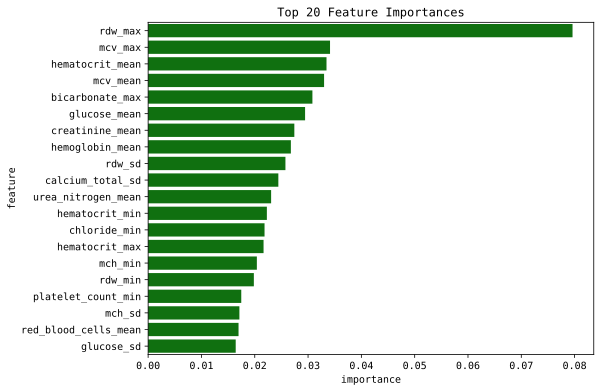

In [12]:
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

np.savez(f'../results/tabnet_base_fpr_tpr_thresholds.npz', fpr, tpr, thresholds)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc:.4f}")
_, lower, upper = bootstrap_auc_ci(y_test, y_proba)
print(f"95% CI = [{lower:.4f}, {upper:.4f}]")

importances = final_model.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(y='feature', x='importance', data=feat_imp, color='green')
plt.title("Top 20 Feature Importances")
plt.show()